# Approach to classification with Convolutional Neural Networks and graph adjacency matrix

Aleksandr Suvorov

6.01.2023

---

Graphs can represent various complex biological systems or the relations of some human parameters.

The present approach focuses on the analysis of exhaled air using a mass spectrometer in healthy patients and patients with cystic fibrosis (CF).
The main aim of the approach was to distinguish healthy subjects from subjects with CF. 

Due to the complexity of the process of normalizing the ratios of the charge and mass of molecules in the exhaled air (due to the rate of breathing of patients, due to other reasons), it was decided to use not direct indicators, but pairwise mass-to-charge ratios between different molecules in the exhaled air.

This approach made it possible to construct a weighted graph for each patient, the vertices of which are molecules, and the edges have weight in the form of relations over nodes:

$$ 
\begin{equation} 
E_{x,y} = MZ(x) / MZ(y) 
\end{equation} 
$$

, where $E$ is a edge weight, $MZ(x)$ and $MZ(y)$ are  mass-to-charge ratios for $x, y$ ions.

For zero values of mass-to-charge ratios imputation of 0.001 were made to prevent divizion by zero.

Next, graphs were treated as adjacency matrices. 

The matrices were sent to Convolutional Neural Network classifier.

Further demonstration will consider a small group of 70 patients in a training set and 35 patients for internal validation.

Target condition was near 50% in both groups (see the information below).

The **dataset** can be found [here](https://docs.google.com/spreadsheets/d/1WfUafDcM12nc7dbuGYBTKC_vTyQVVfXD5ch_BKYqwDQ/edit?usp=share_link).

To make AUC-plots and AUC calculations we can download [`ModPerf module`](https://github.com/aysuvorov/medstats/blob/master/Python_scripts/ModPerf.py) from [`medstats`](https://github.com/aysuvorov/medstats) repo. 
Or we can just use `sklearn` default plotter...

In [6]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

from numpy import linalg as LA
from itertools import combinations
from joblib import Parallel, delayed
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, MinMaxScaler
from sklearn.metrics import roc_auc_score

#pytorch utility imports
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
from torchvision.utils import make_grid
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import warnings
warnings.filterwarnings('ignore')

import sys
# you need to import [`ModPerf module`](https://github.com/aysuvorov/medstats/blob/master/Python_scripts/ModPerf.py) or 
# use any othe construction to plot AUC or access the model performance

# sys.path.append('/home/guest/Documents/medstats/Python_scripts')

import ModPerf as mdp
from importlib import reload

In [7]:
# Global parameters

RS = 42

In [8]:
df = pd.read_csv('./сystic_fibrosis_11_01_2023.csv')

# - `Sample name`` is a patient ID,
# - `Group`` - is a target class (0 - healthy, 1 - CF)
# - `16_00437621316582`,	`17_021539190698192`, ... are molecules (128 in total)
# - the values are mass-to-charge ratios

df.index = [str(x) for x in df['Sample Name']]

X = df.drop(['Group', 'Sample Name'], 1)
Y = df['Group']


In [9]:
df.head()

,Sample Name,Group,16_00437621316582,17_021539190698192,18_038469966740735,18_29915765289428,18_63043828897158,18_87945690818552,18_943778909567843,19_040493421214805,...,429_0919133669904,430_05858392387927,431_0338918422529,443_04198484160145,445_0972017708983,447_05657737924486,517_0325219174968,518_0392964367509,533_0672614483142,575_8644098061574
Id_1,Id_1,0,0.0,328.333333,15256.666667,0.0,0.000000,1862.666667,142.666667,199622.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Id_2,Id_2,0,0.0,287.666667,10707.333333,0.0,0.000000,1628.666667,0.000000,204483.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Id_3,Id_3,0,0.0,242.000000,8218.000000,0.0,0.000000,1581.000000,0.000000,205679.666667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Id_4,Id_4,1,0.0,207.000000,4295.000000,0.0,110.666667,1788.666667,286.666667,202050.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Id_5,Id_5,1,0.0,225.666667,4950.666667,0.0,0.000000,1638.333333,0.000000,204870.666667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
# Defining the functions to produces graphs for individual patients and calculating 128x128 adjustency matrices

def weight_edge_adder(G, P, edges_tuple_lst):
    for n in range(len(edges_tuple_lst)):
        G.edges[edges_tuple_lst[n][0], edges_tuple_lst[n][1]]['weight'] = P[edges_tuple_lst[n][0]] / P[edges_tuple_lst[n][1]]
    return G

def fill_x_graphed(x, patient, nodes_lst):
    p = PatientGraph(nodes_lst)
    p.fit(x, patient)
    return p.to_mtrx()

class PatientGraph(object):
    """
    Version 11.10.2022

    Straight proportions are calculated. If any value is 0, value is transformed 
    to 0.001

    Parameters
    ----------
    :nodes_lst: nodes names usually from data frame columns
    
    """
    def __init__(self, nodes_lst: list):
        self.nodes_lst = nodes_lst
        self.edges_tuple_lst = list(combinations(self.nodes_lst, 2))
        self.G = nx.Graph(self.edges_tuple_lst)

    def fit(self, X: pd.DataFrame, patient: str):
        P_ = X.loc[patient, self.nodes_lst]
        P_.replace(0, 0.001, inplace=True)
        self.G = weight_edge_adder(self.G, P_, self.edges_tuple_lst)

    def to_mtrx(self):
        return nx.to_numpy_array(self.G)

In [11]:
# Finally, we will produce XY_data dataset, where index is patients ID and column has 128x128 adjustency matrices

X_graphed = pd.DataFrame(columns = ['Matrices'], 
    index = X.index)

X_graphed.loc[:, 'Matrices']\
    = Parallel(n_jobs=-1, verbose=0)(
        delayed(fill_x_graphed)(X, patient, nodes_lst=list(X.columns)) \
            for patient in X.index)

XY_data = X_graphed.merge(Y, left_index=True, right_index=True)

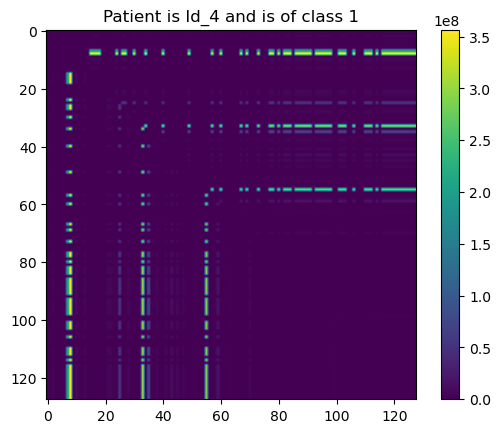

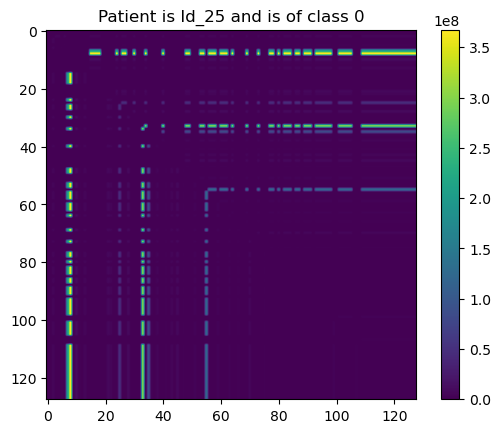

In [12]:
# Every matrix can be plotted as follows:

for patient in ['Id_4', 'Id_25']:

    M = XY_data.loc[patient, 'Matrices']

    plt.imshow(M)
    plt.colorbar()
    plt.title(f'Patient is {patient} and is of class {XY_data.loc[patient, "Group"]}')
    plt.show()

# Also we can plot weighted graphs, but since there are 128 vertices, the plot will be unrepresentative

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
     XY_data.drop('Group', 1), XY_data['Group'], test_size=0.33, random_state=RS)

# Printing information about classes in target variables for train/test:
print('Target parameters: \n')
for target, name in zip([y_train, y_test], ['TRAIN', 'VALIDATION']):
    print(f'- {name} size is {len(target)} patients with {int(target.astype(float).sum())} targets which is {int(target.astype(float).sum() / len(target)*100)}%')

# Printing information about train dataset:
print(f'\nThere are {len(X_train.columns)} columns in the sets')

X_train, X_test = [torch.FloatTensor(x) for x in \
    [X_train['Matrices'], X_test['Matrices']]]
y_train, y_test = [torch.LongTensor(x) for x in [y_train, y_test]]

X_train = torch.reshape(X_train, (-1, 1, 128, 128))
X_test = torch.reshape(X_test, (-1, 1, 128, 128))


Target parameters: 



- TRAIN size is 70 patients with 36 targets which is 51%

- VALIDATION size is 35 patients with 19 targets which is 54%



There are 1 columns in the sets


Now let us construct simple CNN - classifier

In [39]:
# Defining CNN...

def init_weights(self):
    for module in self.modules():
        if (isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear)):
            nn.init.xavier_uniform(module.weight)
            module.bias.data.fill_(0.01)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 15, 1, 1)
        self.conv2 = nn.Conv2d(32, 32, 15, 1, 1)
        self.conv2_drop = nn.Dropout2d(.5)
        self.bnm1 = nn.BatchNorm1d(128, momentum=0.1)    
        self.fc1 = nn.Linear(128, 128)
        self.bnm2 = nn.BatchNorm1d(128, momentum=0.1)
        self.fc2 = nn.Linear(128, 64)
        self.bnm3 = nn.BatchNorm1d(64, momentum=0.1)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 2)

    def forward(self, x):
        x = F.max_pool2d(self.conv1(x), 5)
        x = F.max_pool2d(self.conv2_drop(self.conv2(x)), 5)
        x = x.view(x.size(0), -1)
        x = F.relu(F.dropout(self.fc1(self.bnm1(x)), 0.4))
        x = F.relu(F.dropout(self.fc2(self.bnm2(x)), 0.4))
        x = F.relu(F.dropout(self.fc3(self.bnm3(x)), 0.4))
        x = self.fc4(x)
        return F.log_softmax(x)

# Defining hyperparameters

learning_rate = 0.0001
n_epochs = 250
batch_size = 16

# Loading data

train_loader = torch.utils.data.DataLoader(
    TensorDataset(X_train, y_train),
  batch_size=batch_size, shuffle=True)

val_loader = torch.utils.data.DataLoader(
    TensorDataset(X_test, y_test),
  batch_size=batch_size, shuffle=True)

# Calculationg loss

loss_per_epoch_train = []
loss_per_epoch_val = []

torch.manual_seed(RS)
network = Net()
network.apply(init_weights)

loss_fn=nn.CrossEntropyLoss()
optimizer = optim.Adam(network.parameters(), lr=learning_rate)

for epoch in range(n_epochs):

    loss_per_batch_train = []
    loss_per_batch_val = []

    for x, y in train_loader:          
    
        optimizer.zero_grad()
        pred = network(x)
        loss=loss_fn(pred, y)
        loss_per_batch_train = loss_per_batch_train + [loss.item()]
        loss.backward()
        optimizer.step()

    loss_per_epoch_train = loss_per_epoch_train + [np.array(loss_per_batch_train).mean()]

    network.eval()

    for x, y in val_loader:

        pred_val = network(x)
        loss=loss_fn(pred_val, y)
        loss_per_batch_val = loss_per_batch_val + [loss.item()]

    loss_per_epoch_val = loss_per_epoch_val + [np.array(loss_per_batch_val).mean()]

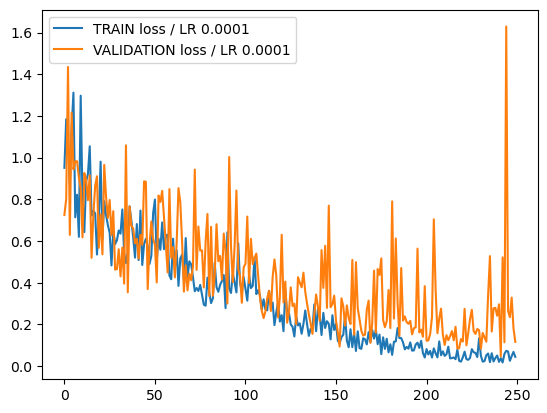

Test data ROC AUC score: 0.9868421052631579




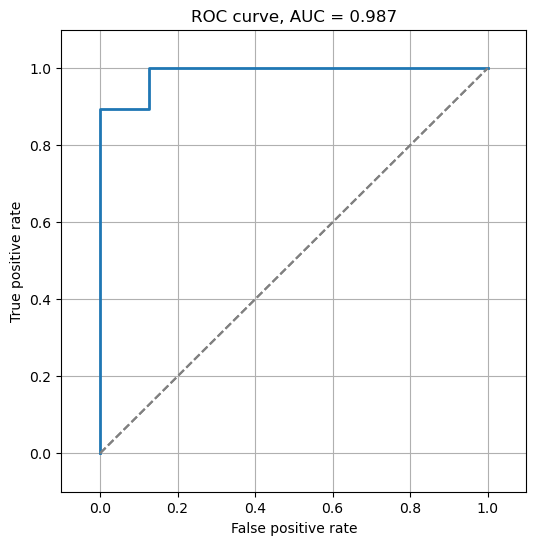

In [40]:
# Plotting loss curves

plt.plot(
    np.array(range(n_epochs)),
    np.array(loss_per_epoch_train),
    label = f'TRAIN loss / LR {learning_rate}'
    )
plt.legend()

plt.plot(
    np.array(range(n_epochs)),
    np.array(loss_per_epoch_val),
    label = f'VALIDATION loss / LR {learning_rate}'
    )
plt.legend()
plt.show()

# Let`s plot the ROC - curve

y_pred = torch.sigmoid(network(X_test)).detach().numpy()[:,1]
print(f'Test data ROC AUC score: {roc_auc_score(y_test.detach().numpy(), y_pred)}\n')

mdp.ROCPlotter_Binary(
    y_test.detach().numpy(), 
    y_pred
    )